# Final Project NLP Fake news detection

### Importing Libraries

In [1]:
# Base level imports for data science work

import numpy as np 
import pandas as pd
import re,string,unicodedata
import os
from os import path

# Visualization Libs
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP Libs
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Additional Libs
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

# Deep Learning Libs
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# time
import time

### Let's explore our data

In [2]:
start = time.time()

# Import our data
#source: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
real = pd.read_csv("Data/True.csv")
fake = pd.read_csv("Data/Fake.csv")

In [3]:
#Check if the dataset are ordered the same
(fake.shape,real.shape)


((23481, 4), (21417, 4))

In [4]:
print("There are ", len(real), " real news in \"True.csv\".")
print("Here are its first five observations.")
real.head()

There are  21417  real news in "True.csv".
Here are its first five observations.


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
print("There are ", len(fake), " fake news in \"Fake.csv\".")
print("Here are its first five observations.")
fake.head()

There are  23481  fake news in "Fake.csv".
Here are its first five observations.


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


I'll add a new column 'target' as a means of reference wheter or not it is a real news or fake news then, join them.

In [6]:
# creating new category for whether they are true or fake.
real['target'] = 1 
fake['target'] = 0
#Joining the 2 datasets
data = pd.concat([fake, real])

In [7]:
data.shape

(44898, 5)

In [8]:
data.sample(5)

,title,text,subject,date,target
15674,"Slovakia's far-right party, ruling leftists lo...",BRATISLAVA (Reuters) - The far-right People s ...,worldnews,"November 5, 2017",1
15670,Billionaire Saudi prince Alwaleed detained in ...,"DUBAI, - Billionaire Saudi Arabian Prince Alwa...",worldnews,"November 5, 2017",1
21006,THE BEST ANTI-HILLARY AD EVER MADE…You’ll Want...,The Ted Cruz campaign has identified the enemy...,left-news,"Feb 12, 2016",0
12600,BREAKING VIDEO: HILLARY CLINTON STUMBLES Up St...,Ladies and gentlemen the Democrats have dumpe...,politics,"Oct 27, 2016",0
6510,Brexit campaigner Farage to attend Trump inaug...,LONDON (Reuters) - Leading Brexit campaigner N...,politicsNews,"January 5, 2017",1


### Visulization of our dataset structure

([<matplotlib.axis.XTick at 0x22a62b65460>,
 [Text(0, 0, 'Fake'), Text(1, 0, 'Real')])

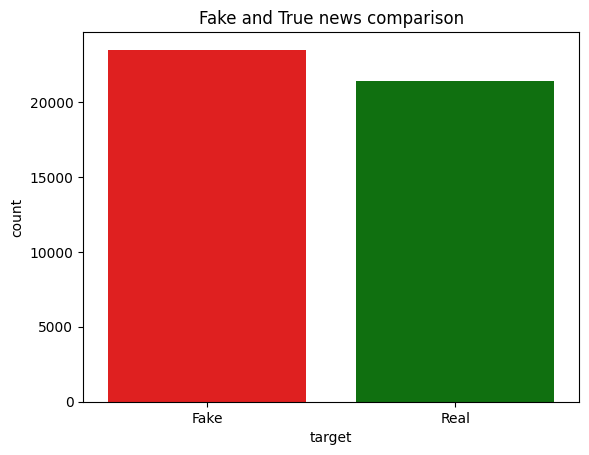

In [9]:
plt.title('Fake and True news comparison')
sns.countplot(x='target',data=data,palette=['red','green'])
plt.xticks([0, 1], ['Fake', 'Real'] )

#                      ## or use this 
# import plotly.graph_objects as go
# colors = ['gold', 'mediumturquoise']
# labels = ['Fake','Real']
# values = data['target'].value_counts()/data['target'].shape[0]

# fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
# fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
#                   marker=dict(colors=colors, line=dict(color='#000000', width=2)))
# fig.update_layout(
#     title_text="Target Balance",
#     title_font_color="white",
#     legend_title_font_color="yellow",
#     paper_bgcolor="black",
#     plot_bgcolor='black',
#     font_color="white",
# )
# fig.show()
# #source: https://www.kaggle.com/code/ohseokkim/fake-news-easy-nlp-text-classification


We can see that the data are fairly balance with fake news being slightly bigger.

In [10]:
print("There is a total of",len(real)+len(fake), 'news articles')

There is a total of 44898 news articles


In [11]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

Out of the 44898 news articles, we are fortunate to have no null values.

In [12]:
print("There are",len(data.subject.value_counts()), "different subjects that are covered in this dataset")

There are 8 different subjects that are covered in this dataset


In [13]:
pd.DataFrame(data.groupby(['subject','target'])['title'].count()).rename(columns = {'title':'amount'})

,,amount
subject,target,
Government News,0,1570
Middle-east,0,778
News,0,9050
US_News,0,783
left-news,0,4459
politics,0,6841
politicsNews,1,11272
worldnews,1,10145


We notice that only 2 subjects out of 8 are real news.

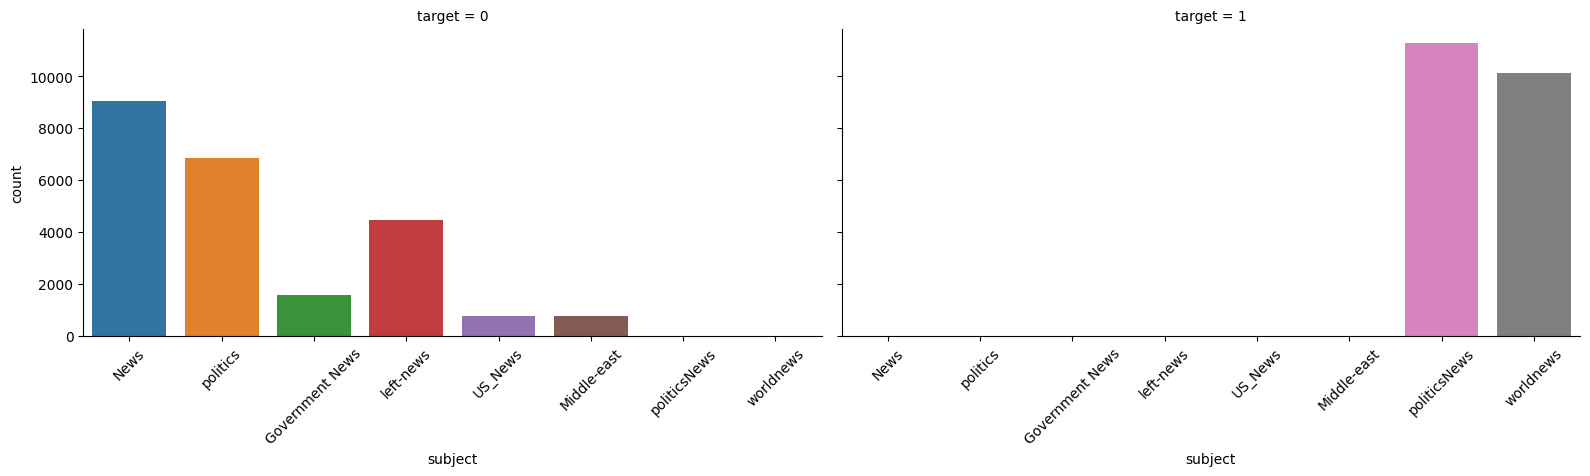

In [14]:
### dont forget plot
g = sns.catplot(x="subject", col="target",
                data=data, kind="count",
                height=4, aspect=2)

#Rotating the xlabels
g.set_xticklabels(rotation=45)

### Converting the date columns to datetime format

Because the "date" column is not formated correctly, To demonstrate how news is transmitted in real time

In [15]:
data['date'].value_counts()

December 20, 2017                                                                                                                                        182
December 6, 2017                                                                                                                                         166
November 30, 2017                                                                                                                                        162
November 9, 2017                                                                                                                                         158
October 13, 2017                                                                                                                                         155
                                                                                                                                                        ... 
August 6, 2016                                            

Let's remove the links that are in the data columns

In [16]:
#Only keeps the wich has months in it.
data=data[data.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec")]

In [17]:
print('Here we can see that all links has been removed')
data['date'].value_counts()

Here we can see that all links has been removed


December 20, 2017     182
December 6, 2017      166
November 30, 2017     162
November 9, 2017      158
October 13, 2017      155
                     ... 
December 4, 2017        1
December 25, 2016       1
October 9, 2017         1
October 22, 2017        1
Jun 21, 2015            1
Name: date, Length: 2391, dtype: int64

Now that the links won't caused any trouble, we can convert our data with "pd.datetime"

In [18]:
#Converting argument to datetime
data = data.copy()
data['date'] = pd.to_datetime(data['date'])

In [19]:
print("We can confirm that the date columns has been formated")
data.sample(5)

We can confirm that the date columns has been formated


,title,text,subject,date,target
3154,Trump tweet not meant to confirm he is under i...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,2017-06-16,1
19596,CONSERVATIVE FOX News Houston Host FIRED For S...,The Left s suppression of speech and viewpoint...,left-news,2016-11-18,0
9084,JUST IN: CROOKED DOJ OFFICIAL Didn’t Reveal Th...,We ve been covering the curious case of DOJ of...,politics,2018-02-14,0
4472,Howard Dean ROASTS Trump Over Debate Sniffles...,"In the first half of the debate, Donald Trump ...",News,2016-09-27,0
5590,Trump accuser follows Cosby playbook by pursui...,NEW YORK (Reuters) - When former reality telev...,politicsNews,2017-02-08,1


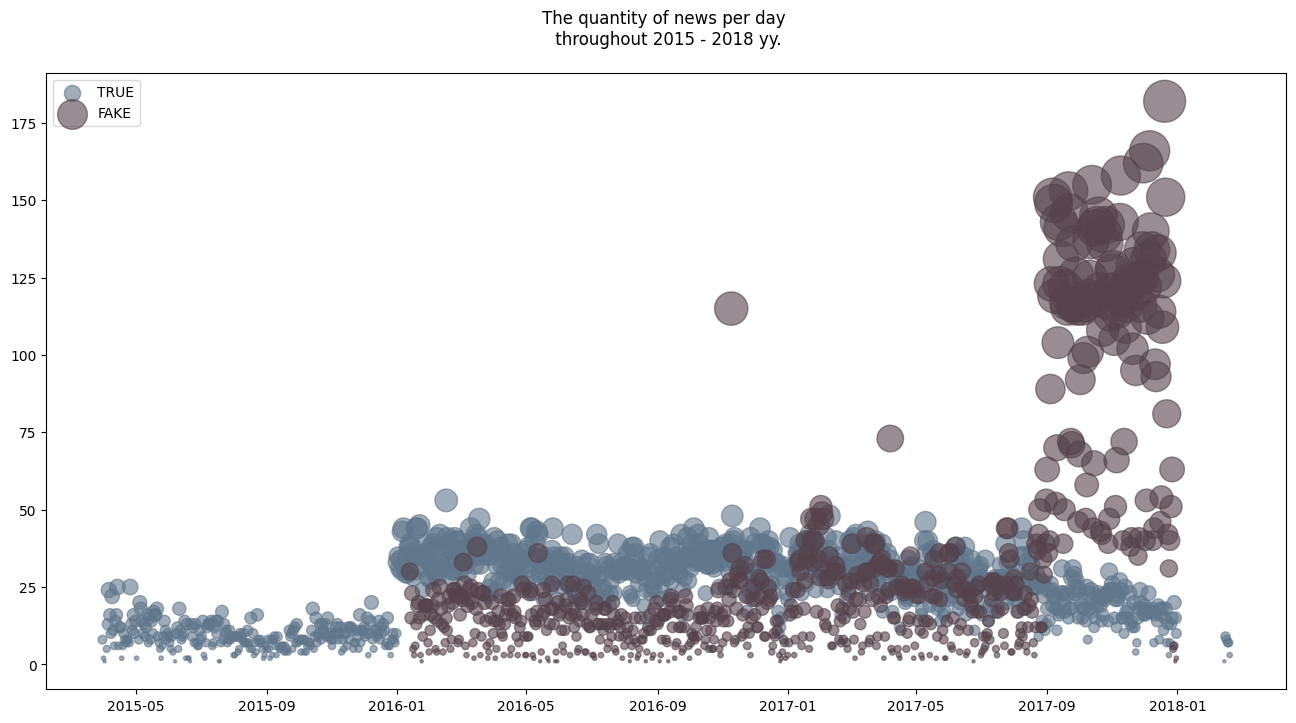

In [20]:
subset_fake = data[data['target']==1].groupby('date').count().iloc[:,:1]
subset_true = data[data['target']==0].groupby('date').count().iloc[:,:1]
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(16,8))
colours = ['#55424b', '#5f768b']
sizes_true = subset_true.iloc[:, 0]*5
sizes_fake = subset_fake.iloc[:, 0]*5
plt.scatter(subset_true.index, subset_true.iloc[:, 0], 
            color = colours[1], label = "TRUE", alpha = 0.6,
            s = sizes_true)
plt.scatter(subset_fake.index, subset_fake.iloc[:, 0], 
            color = colours[0], label = "FAKE", alpha = 0.6,
            s = sizes_fake)
plt.title("The quantity of news per day \n throughout 2015 - 2018 yy.\n")
plt.legend(loc = 'upper left')
plt.show()

## Cleaning

Let's combine the title and text of each news item into a single column.

In [21]:
data['text'] = data['title'] + ' ' + data['text']
data.drop(['subject','title'], axis = 1, inplace = True)
data.sample(5)

,text,date,target
14637,French military says coalition opposed IS with...,2017-11-16,1
7891,Sanders supporters seethe over Clinton's leake...,2016-10-08,1
2090,Leading Democrat: Critics can't conclude Trump...,2017-08-20,1
19003,U.S. Debt DECREASED By $68 BILLION In First Mo...,2017-03-10,0
20271,Trump to call Mexico's Pena Nieto in earthquak...,2017-09-12,1


#### Lower Case

In [22]:
data['text'] = data['text'].str.lower()
data.sample(5)

,text,date,target
11060,nasty women! ivanka trump booed…hissed by unbe...,2017-04-25,0
3646,nc’s gop-run board of elections just smacked ...,2016-11-29,0
15921,exclusive: u.s. pursues direct diplomacy with ...,2017-11-01,1
10007,what? first graders asked not to use the words...,2017-08-31,0
10245,verified #fakenews ap attempts to discredit fo...,2017-08-02,0


#### remove wrong confusing character

In [23]:
def clean_text(text):
    
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('Reuters','',text)
    return text

data['text'] = data['text'].apply(lambda x:clean_text(x))
data.sample(5)
#source https://stackoverflow.com/questions/55187374/cleaning-text-with-python-and-re

,text,date,target
9024,ryan says democratic sitin demanding gun contr...,2016-06-22,1
4025,trump’s problems with women get worse as anot...,2016-10-27,0
22109,forsaken sultan erdogan isolated ahead trump m...,2017-05-16,0
6057,us ethics lawsuits against trump part of group...,2017-01-25,1
13667,update obama appointed us attorney intervenes…...,2016-06-20,0


#### Removing stop words:

**Stopwords: ** A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. We would not want these words to take up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to stop words. NLTK(Natural Language Toolkit) in python has a list of stopwords stored in 16 different languages.

Source: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In [24]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data.sample(5)

,text,date,target
4337,twitter case shows breadth us power probe anti...,2017-04-08,1
18848,paul joseph watson happy air strike syria…here...,2017-04-08,0
21711,disney worker tells horror story forced train ...,2015-05-21,0
17447,raqqa evacuation included foreign fighters loc...,2017-10-15,1
18437,trump wins supreme court rules travel ban unan...,2017-06-26,0


#### Lemmatizing words:

Lemmatization was performed, so only root words were retained.

In [25]:
wnl  = WordNetLemmatizer()
data["text"] = data["text"].apply(lambda x: nltk.word_tokenize(x))
data["text"] = data["text"].apply(lambda x: " ".join([wnl.lemmatize(word) for word in x]))
data.head()

,text,date,target
0,donald trump sends embarrassing new year ’ s e...,2017-12-31,0
1,drunk bragging trump staffer started russian c...,2017-12-31,0
2,sheriff david clarke becomes internet joke thr...,2017-12-30,0
3,trump obsessed even obama ’ s name coded websi...,2017-12-29,0
4,pope francis called donald trump christmas spe...,2017-12-25,0


## Deeper analysis:

### Wordcloud

The size of each word represents its frequency or relevance in a **wordcloud**, which is a data visualisation tool for visualising text data.

(-0.5, 3029.5, 1090.5, -0.5)

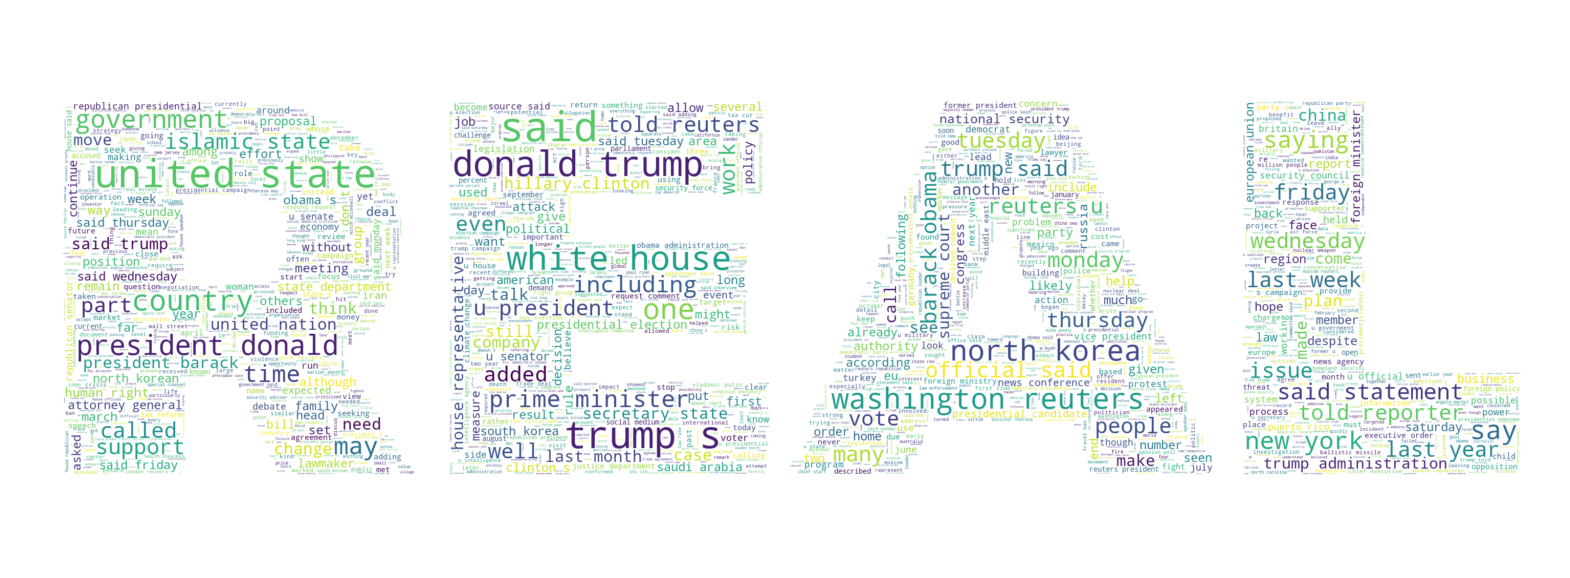

In [26]:
plt.figure(figsize = (20,20))

true_news = " ".join(data[data["target"]==1]["text"])

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read image color
coloring = np.array(Image.open(path.join(d, "Data/real.jpg")))
stopwords = set(STOPWORDS)

wc = WordCloud(background_color="white", max_words = 2000 , width = 1600 , height = 800, mask=coloring,
               stopwords=stopwords, max_font_size=80, random_state=42)

# create wordcloud
wc.generate(true_news)

# create coloring from image
image_colors = ImageColorGenerator(coloring)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 3029.5, 1090.5, -0.5)

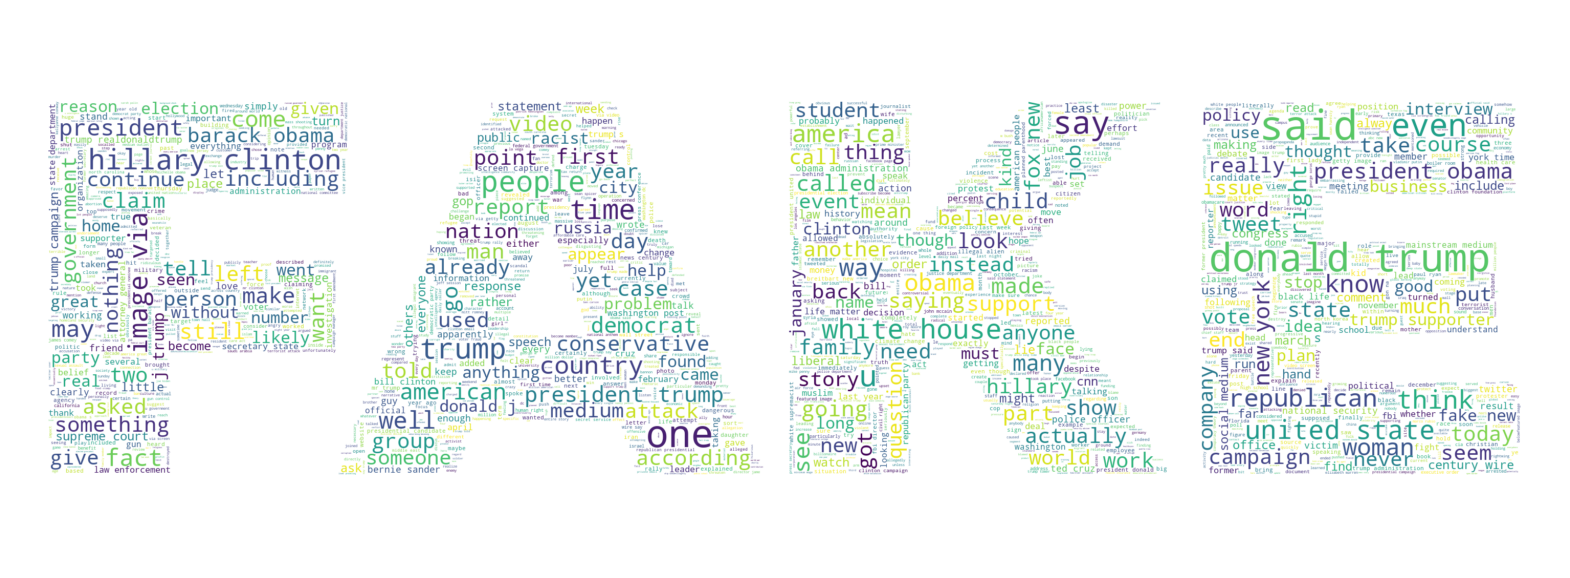

In [27]:
plt.figure(figsize = (20,20))

fake_news = " ".join(data[data["target"]==0]["text"])

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
# read image color
coloring = np.array(Image.open(path.join(d, "Data/fake.jpg")))
stopwords = set(STOPWORDS)

wc = WordCloud(background_color="white", max_words = 2000 , width = 1600 , height = 800, mask=coloring,
               stopwords=stopwords, max_font_size=80, random_state=42)

# create wordcloud
wc.generate(fake_news)

# create coloring from image
image_colors = ImageColorGenerator(coloring)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

Because majority of the articles were classified as political, there are similar representations such as 'Donald Trump' and 'United States.'

### N-Grams

In [28]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#source: https://www.guruguru.science/competitions/13/discussions/c73cb36a-6b8f-4a13-889f-4f4d5d7435bb/

#### 1.                                                           Unigram Analysis

True news Unigram

<Axes: >

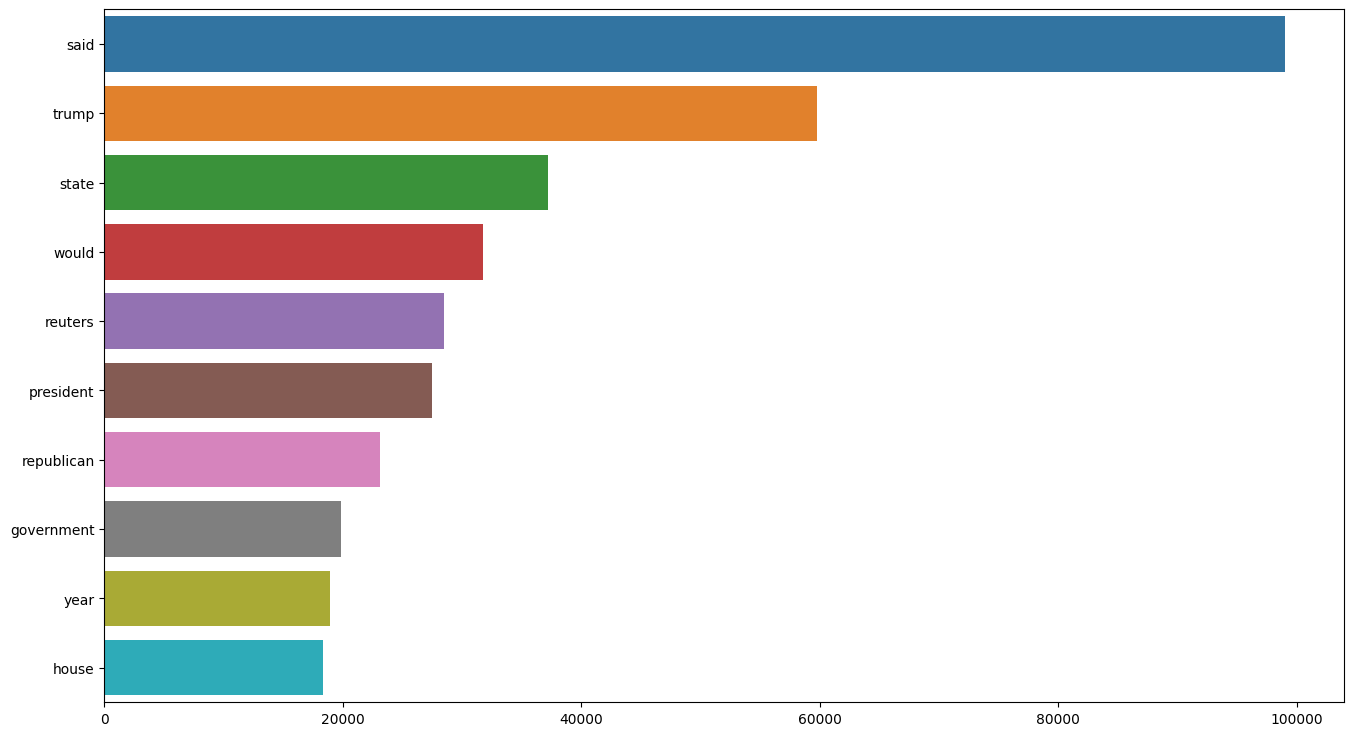

In [29]:
plt.figure(figsize = (16,9))
True_ngram = data[data["target"]==1]["text"]
top_10_uni = get_top_text_ngrams(True_ngram,10,1)
top_10_uni = dict(top_10_uni)
sns.barplot(x=list(top_10_uni.values()),y=list(top_10_uni.keys()))

Fake news Unigram

<Axes: >

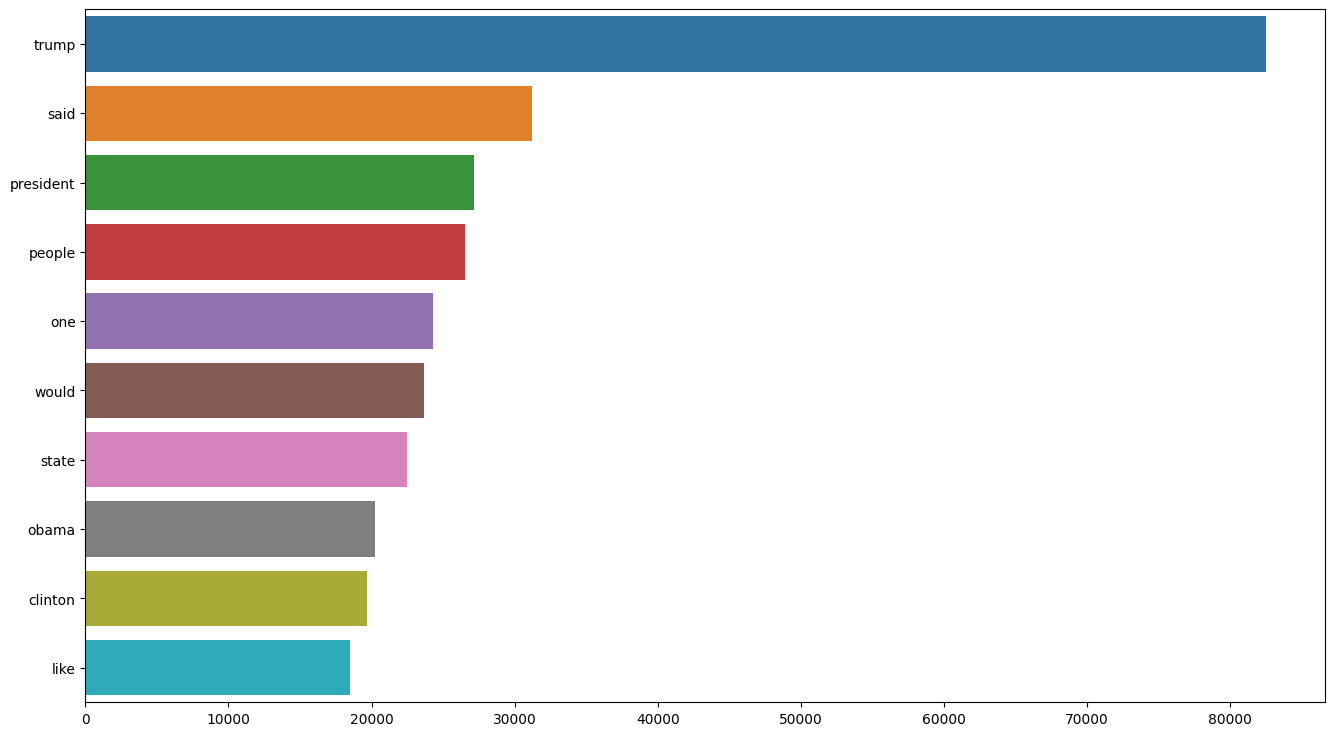

In [30]:
plt.figure(figsize = (16,9))
Fake_ngram = data[data["target"]==0]["text"]
top_10_uni = get_top_text_ngrams(Fake_ngram,10,1)
top_10_uni = dict(top_10_uni)
sns.barplot(x=list(top_10_uni.values()),y=list(top_10_uni.keys()))

#### 2.            Bigram Analysis

True news Bigram

<Axes: >

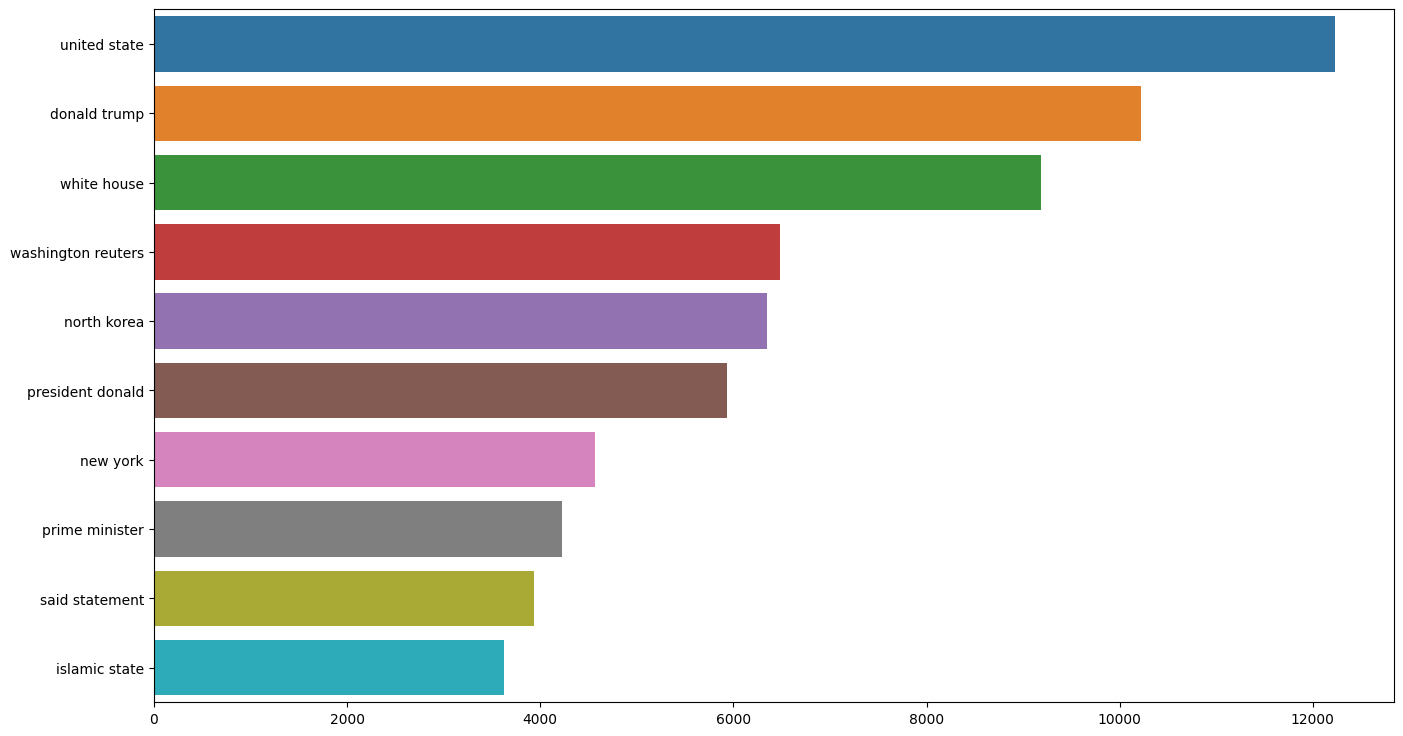

In [31]:
plt.figure(figsize = (16,9))
True_ngram = data[data["target"]==1]["text"]
top_10_bi = get_top_text_ngrams(True_ngram,10,2)
top_10_bi = dict(top_10_bi)
sns.barplot(x=list(top_10_bi.values()),y=list(top_10_bi.keys()))

Fake news Bigram

<Axes: >

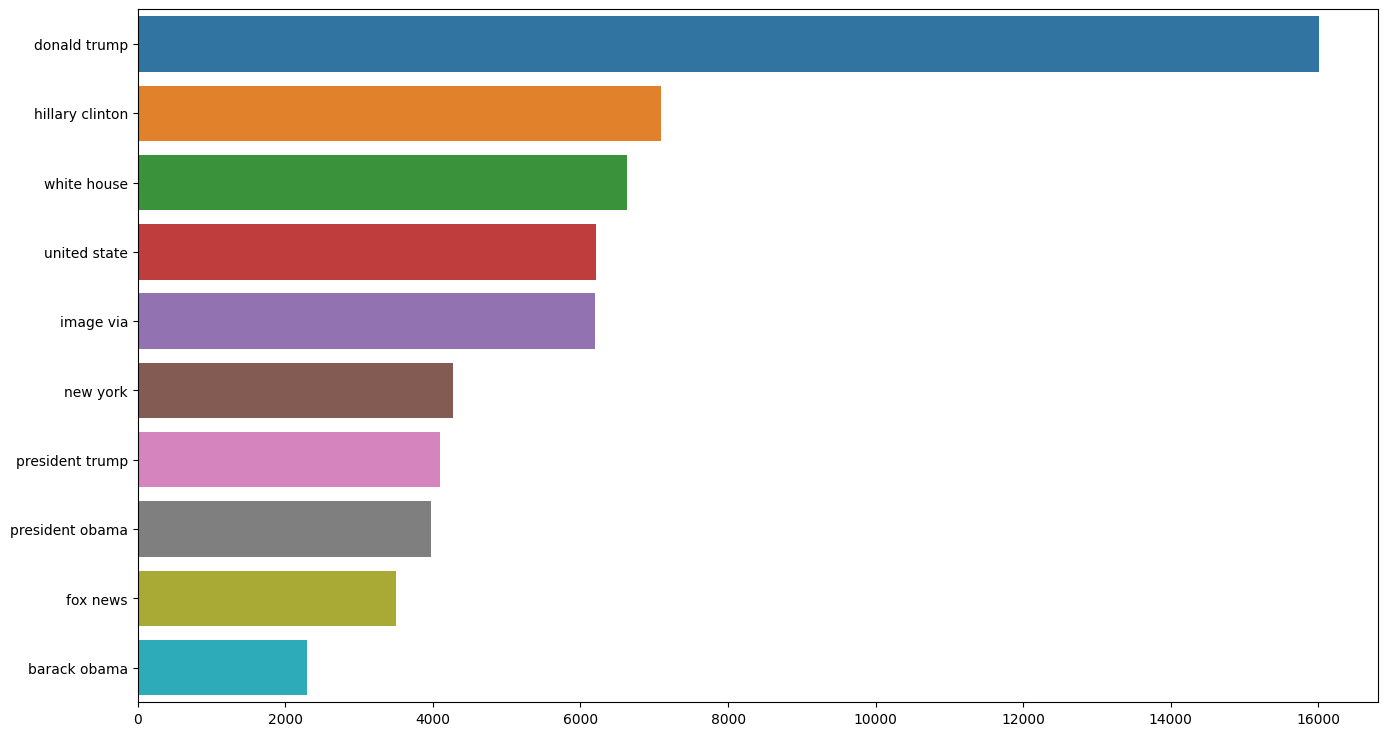

In [32]:
plt.figure(figsize = (16,9))
Fake_ngram = data[data["target"]==0]["text"]
top_10_bi = get_top_text_ngrams(Fake_ngram,10,2)
top_10_bi = dict(top_10_bi)
sns.barplot(x=list(top_10_bi.values()),y=list(top_10_bi.keys()))

#### 3.            Trigram Analysis

True news Trigram

<Axes: >

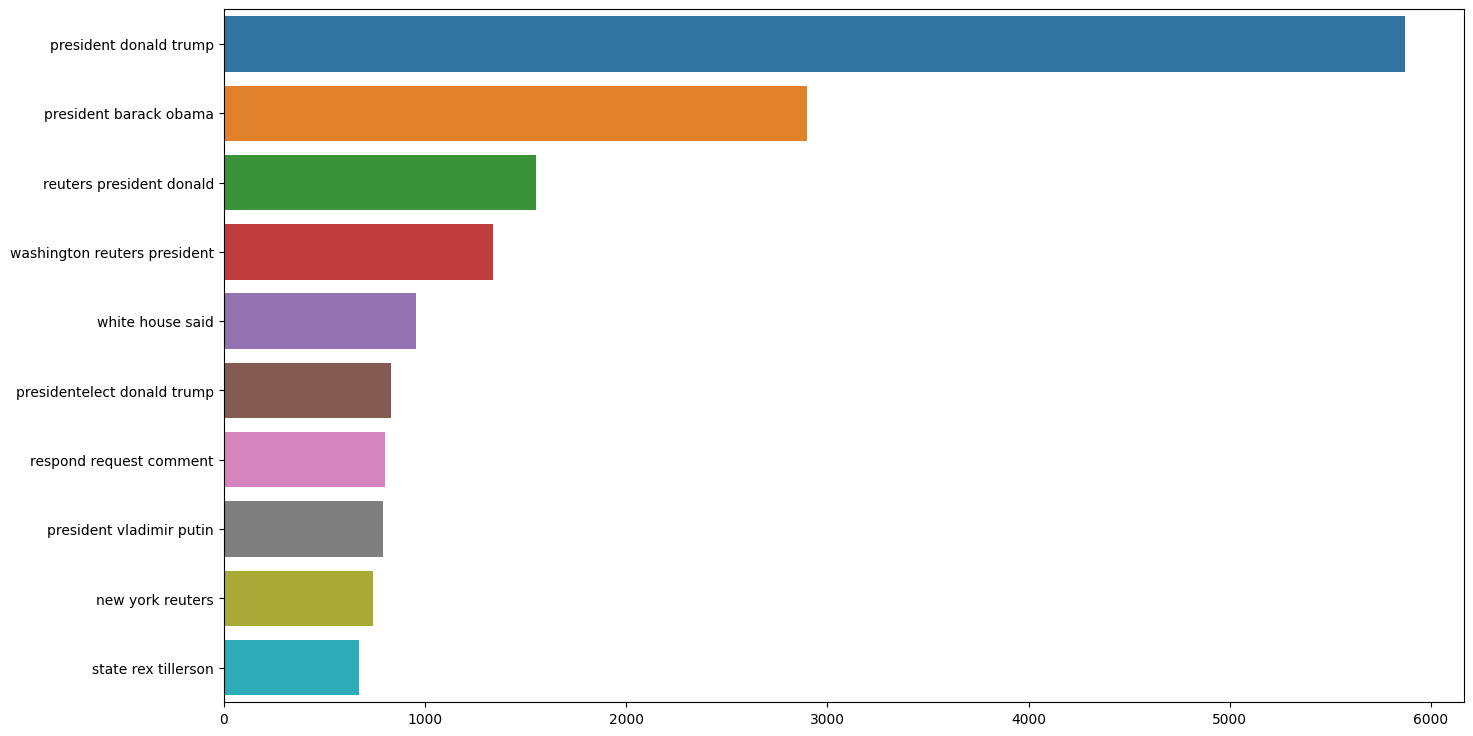

In [33]:
plt.figure(figsize = (16,9))
True_ngram = data[data["target"]==1]["text"]
top_10_tri = get_top_text_ngrams(True_ngram,10,3)
top_10_tri = dict(top_10_tri)
sns.barplot(x=list(top_10_tri.values()),y=list(top_10_tri.keys()))

Fake news Trigram

<Axes: >

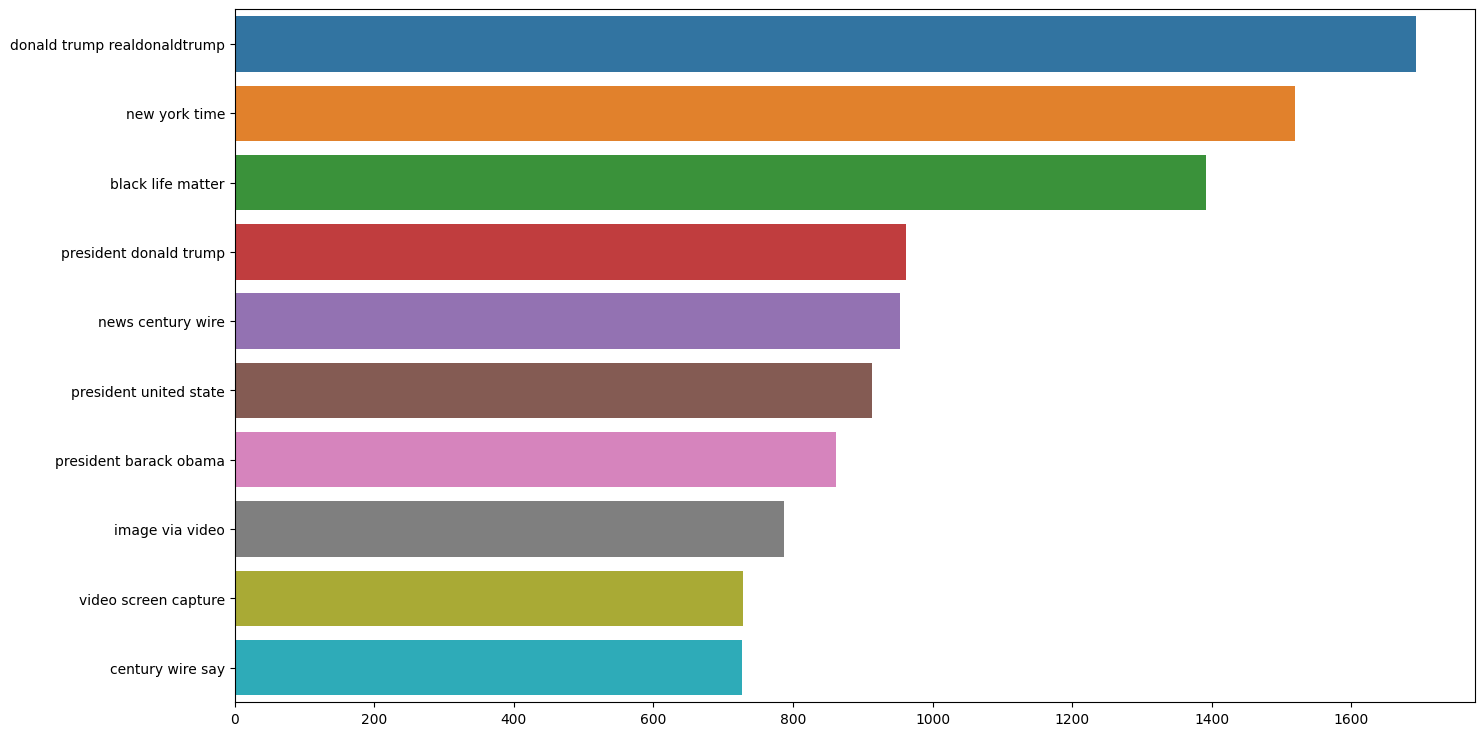

In [34]:
plt.figure(figsize = (16,9))
Fake_ngram = data[data["target"]==0]["text"]
top_10_tri = get_top_text_ngrams(Fake_ngram,10,3)
top_10_tri = dict(top_10_tri)
sns.barplot(x=list(top_10_tri.values()),y=list(top_10_tri.keys()))

## Training

Splitting dataset into training and test sets.

In [35]:
y = data['target']
x = data['text']
X_train, X_test, y_train, y_test = train_test_split(x, y)

In [36]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)
print(count_train.shape)

(33666, 166572)


### Naive Bayes

              precision    recall  f1-score   support

        Fake     0.9583    0.9473    0.9528      5899
        True     0.9423    0.9543    0.9483      5323

    accuracy                         0.9506     11222
   macro avg     0.9503    0.9508    0.9505     11222
weighted avg     0.9507    0.9506    0.9506     11222

The Logistic Regression code took: 0.0 minutes to run


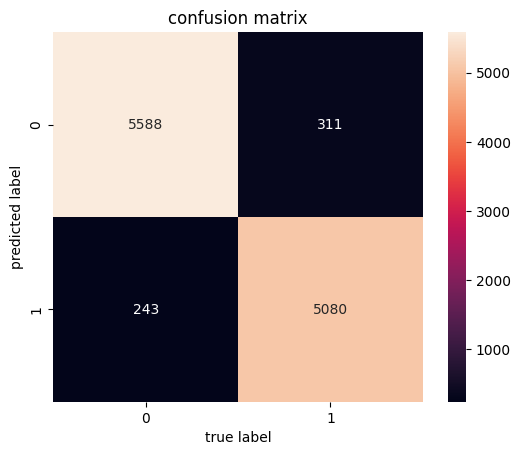

In [37]:
start_nb = time.time()

nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)

pred1 = nb_classifier.predict(count_test)

print(classification_report(y_test, pred1, target_names = ['Fake','True'], digits=4))

# Confusion matrix
mat1 = confusion_matrix(y_test, pred1)
sns.heatmap(mat1, square=True, annot=True, fmt='d')
plt.title('confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

end_nb = time.time()
print("The Logistic Regression code took:", round((end_nb-start_nb)/60,1), "minutes to run")

### Logistic Regression

              precision    recall  f1-score   support

        Fake     0.9966    0.9951    0.9958      5899
        True     0.9946    0.9962    0.9954      5323

    accuracy                         0.9956     11222
   macro avg     0.9956    0.9957    0.9956     11222
weighted avg     0.9956    0.9956    0.9956     11222

The Logistic Regression code took: 0.1 minutes to run


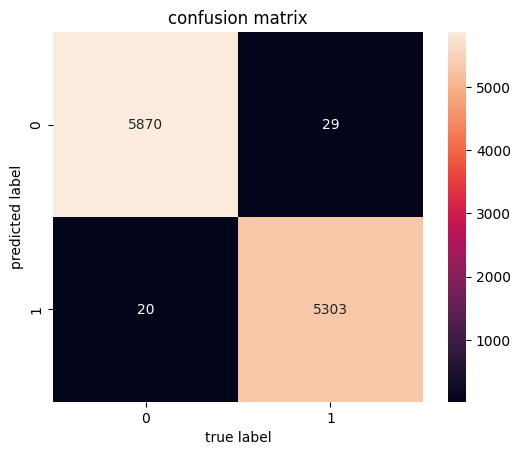

In [38]:
start_lr = time.time()

lr_classifier = LogisticRegression(solver='lbfgs', max_iter=6000)
lr_classifier.fit(count_train, y_train)

pred2 = lr_classifier.predict(count_test)

print(classification_report(y_test, pred2, target_names = ['Fake','True'], digits=4))

# Confusion matrix

mat2 = confusion_matrix(y_test, pred2)
sns.heatmap(mat2, square=True, annot=True, fmt='d')
plt.title('confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');


end_lr = time.time()
print("The Logistic Regression code took:", round((end_lr-start_lr)/60,1), "minutes to run")

### Decision Tree

              precision    recall  f1-score   support

        Fake     0.9954    0.9963    0.9958      5899
        True     0.9959    0.9949    0.9954      5323

    accuracy                         0.9956     11222
   macro avg     0.9956    0.9956    0.9956     11222
weighted avg     0.9956    0.9956    0.9956     11222

The Decision Tree code took: 0.3 minutes to run


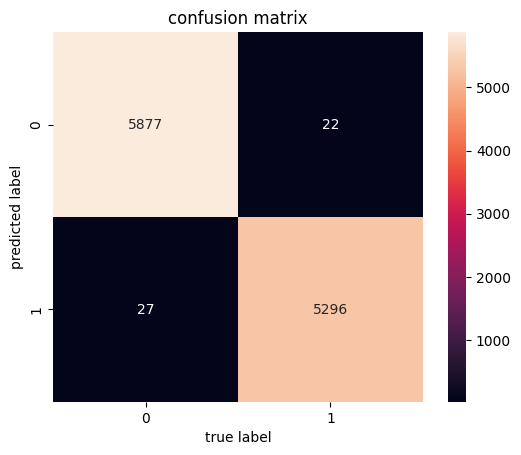

In [39]:
start_dt = time.time()

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(count_train, y_train)

pred3 = dt_classifier.predict(count_test)

print(classification_report(y_test, pred3, target_names = ['Fake','True'], digits=4))

# Confusion matrix
mat3 = confusion_matrix(y_test, pred3)
sns.heatmap(mat3, square=True, annot=True, fmt='d')
plt.title('confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

end_dt = time.time()
print("The Decision Tree code took:", round((end_dt-start_dt)/60,1), "minutes to run")

### SVM

              precision    recall  f1-score   support

        Fake     0.9930    0.9927    0.9929      5899
        True     0.9919    0.9923    0.9921      5323

    accuracy                         0.9925     11222
   macro avg     0.9925    0.9925    0.9925     11222
weighted avg     0.9925    0.9925    0.9925     11222

The SVM code took: 18.8 minutes to run


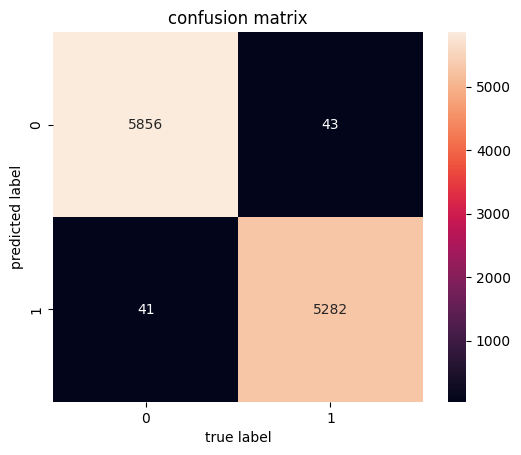

In [40]:
start_svm = time.time()

svm_classifier = SVC()
svm_classifier.fit(count_train, y_train)

pred4 = svm_classifier.predict(count_test)

print(classification_report(y_test, pred4, target_names = ['Fake','True'], digits=4))

# Confusion matrix
mat4 = confusion_matrix(y_test, pred4)
sns.heatmap(mat4, square=True, annot=True, fmt='d')
plt.title('confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');


end_svm = time.time()
print("The SVM code took:", round((end_svm-start_svm)/60,1), "minutes to run")

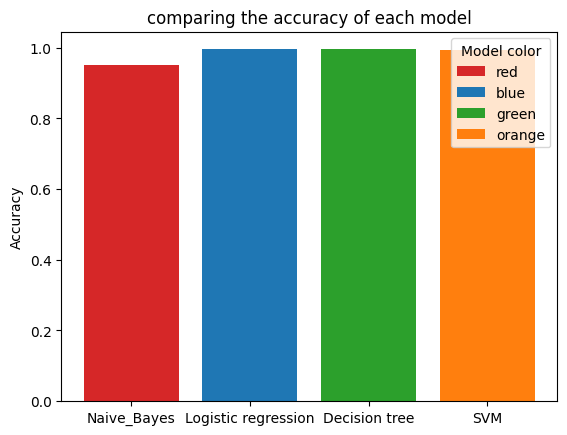

In [44]:
fig, ax = plt.subplots()

Models = ['Naive_Bayes', 'Logistic regression', 'Decision tree', 'SVM']
counts = [0.9506, 0.9956, 0.9956,0.9925]
bar_labels = ['red', 'blue', 'green', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

ax.bar(Models, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Accuracy')
ax.set_title('comparing the accuracy of each model')
ax.legend(title='Model color')

plt.show()

In [42]:
end = time.time()
print("The total code took:", round((end-start)/60,1), "minutes to run")

The total code took: 25.5 minutes to run
